<a href="https://colab.research.google.com/github/small-qiu/Deep_learning/blob/master/highd_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
     raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)


import tensorflow.compat.v1 as tf
import numpy as np
tf.disable_v2_behavior()

Found GPU at: /device:GPU:0
2.3.0
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# 导入数据
# 挂载云端硬盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 读取文件
import os
os.chdir('/content/drive/My Drive/Heston_model/')  # 已经进入目录下

In [8]:
import pandas as pd
import numpy as np
# 构造和50w相同的初始S0和V0,和蒙特卡洛一样
xchi0 = pd.read_excel(r'x0_chi0.xlsx')
x0 = np.array(xchi0['x0'])
chi0 = np.array(xchi0['chi0'])

# 基本参数设置
T = 20/250 
dt = 1/250
D = int(T/dt)
a = 0.95
b = 0.8
c = 0.1
sigma = 0.1
rho = -0.9
gamma = 0.7 
r = 0.03  # 无风险利率
K = 100 # 标的价格
M = 25 # 资产个数
def paths50d(num):
    # 生成数据 S.shape = (num,D*M)
    # 一次性生成路路径
    x = np.zeros([num,D*M])
    chi = np.zeros([num,D*M])
    w = np.zeros([M,1])

    for i in range(M):
        x[:,i*D] = x0[i]
        chi[:,i*D] = chi0[i]
        w[i,0] = 1/M
    for k in  range(M):
        for i in  range(1,D):    
            j = k*D + i
            W1 = np.random.randn(num)
            W1_5 = np.random.randn(num)
            W2 = W1*rho + W1_5*np.sqrt(1-rho**2)
            x[:,j] = x[:,j-1] +(r-0.5*pow(sigma/(1-gamma*chi[:,j-1]),2))*dt+sigma/(1-gamma*chi[:,j-1])*np.sqrt(dt)*W1
            chi[:,j] = chi[:,j-1] + b*(a-chi[:,j-1])*dt+c*np.sqrt((1-chi[:,j-1])*chi[:,j-1])*np.sqrt(dt)*W2  
    # 下面做蒙特卡洛仿真
    # 收盘价

    x_end =  np.zeros([num,M])
    for i in range(M):
        # 提取做好时刻的值
        x_end[:,i] = x[:,(i+1)*D-1]

    c_end = np.zeros([num,1])
    for i in range(num):
        c_end[i] = [max(h-K,0) for h in np.dot(np.exp(x_end[i,:]),w)]
    c0 = np.mean(c_end)*np.exp(-r*T)
    x = np.reshape(x,(num,M,D))
    chi = np.reshape(chi,(num,M,D))
    return x,chi,c0,c_end


In [15]:

## 50w 条数据计时器**** rework
import time
time_start=time.time()
x50w,chi50w,c50w,c_endt50w = paths50d(500000)
time_end=time.time()
print('time cost',time_end-time_start,'s')
print(c50w)

time cost 71.14879941940308 s
0.5862033926606136


In [18]:
np.random.seed(7)
# 得到10000条训练数据

numtrain = 10000
S,V,c1,c_endt = paths50d(numtrain)
X_train = np.zeros([numtrain,2*M,D])     
for i in range(numtrain):
    X_train[i,:] = np.vstack((S[i,:],V[i,:]))
print(X_train.shape)#数据读入和预处理,读取数据较慢
# c_end是最后的max(st,w-k,0),可作为loss的pre


# 验证数据 256 条数据
numval = 256
st_val,vt_val,c2,c_endv = paths50d(numval)
X_val = np.zeros([numval,2*M,D])
for i in range(numval):
    X_val[i,:] = np.vstack((st_val[i,:],vt_val[i,:]))
print(X_val.shape)
print(c_endt.shape,c_endv.shape)
print(f'1000条蒙特卡洛：{c1}\n     256条验证：{c2}')
print(f'   50w蒙特卡洛: {c50w}')
print('数据构造完成！')

(10000, 50, 20)
(256, 50, 20)
(10000, 1) (256, 1)
1000条蒙特卡洛：0.5739613901603743
     256条验证：0.571293964110733
   50w蒙特卡洛: 0.5862033926606136
数据构造完成！


In [22]:
import time  
import math
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import random
from tensorflow.python.training.moving_averages import assign_moving_average   # 移动平均
from scipy.stats import multivariate_normal as normal            # 产生正态分布随机数
from tensorflow.python.ops import control_flow_ops               #用于控制流  
from tensorflow import random_normal_initializer as norm_init    #生成具有正态分布的张量的初始化器
from tensorflow import random_uniform_initializer as unif_init   #生成具有均匀分布的张量的初始化器
from tensorflow import constant_initializer as const_init        #生成具有常量值的张量的初始化器
tf.disable_v2_behavior()

class OptionPricing(object):
    def __init__ (self,sess):

        self.sess = sess   # 会话       
        self.d = 2*M      # 数据的维度
        self.T = 20.0/250      # 每一条路径的时间长度
        # parameters for the algorithm
        self.dt = 1/250    # 每一个路径中数据时间间隔，delta t = 1/32
        self.n_time = int(self.T/self.dt)     # 有20个t
        self.n_layer = 4    # 神经网络的层数
        self.n_neuron = [self.d ,self.d+10,self.d+10, self.d]    # 各层神经元的个数，对应输入、隐藏层1、隐藏层2、输出
        self.batch_size = 128     # 一次用到个路径计算，64*4=256
        self.valid_size =256     # 256个蒙特卡洛样本（路径）
        self.n_maxstep = 1000    # 迭代步数
        self.n_displaystep = 50     # 每100步print一次
        self.learning_rate = 5e-4    # 学习率
        self.Yini = [0.3,0.8]      # 初始值Y0的最大最小值
        # some basic constants and variables

        self.sqrth = math.sqrt(self.dt)    # 根号delta t，后面用于计算
        self.t_stamp = np.arange(0,self.n_time)*self.dt  # 时间戳，累计的时间
        self._extra_train_ops = []  # batch移动平均值操作，其中需要额外训练的beta和gamma
        
        self.c = 0.1
        self.sigma = 0.1
        self.gamma = 0.7
        self.r = 0.03
        self.rho = -0.9
        self.paths = 10000    ## 所用总路径数
        self.epoch_splits = int(self.paths/self.batch_size) - 1 
        
    def train(self):
        # 主要函数，用于神经网络的训练
        start_time = time.time()   # 起始时间
        self.global_step = \
            tf.get_variable('global_step', [] ,
                              initializer = tf.constant_initializer(1),
                              trainable = False,dtype = tf.int32 )   # 没有添加到要训练的变量列表，计步器
        trainable_vars = tf.trainable_variables()  # 查看可训练的变量
        grads = tf.gradients(self.loss,trainable_vars)  # loss可训练变量的梯度
        optimizer = tf.train.AdamOptimizer(self.learning_rate)    # 梯度优化器
        apply_op = optimizer.apply_gradients(zip(grads,trainable_vars) ,    # 将梯度用来更新trainable_vars列表中的东西
                                          global_step = self.global_step)   # 更新梯度和迭代次数
        
        train_ops = [apply_op] + self._extra_train_ops   # 添加操作，相当于list1.extand(list2)
        self.train_op = tf.group(* train_ops)   # tf.group(*train_ops)组合*train_ops的操作
        
        self.loss_history = []   # 用于记录loss值
        self.init_history = []   # 用于记录Y0的值
        
        # for validation,256条蒙特卡洛做验证集
        dW_valid , X_valid,c_endv = self.sample_path(self.valid_size,0,tra=False)   # 生成数据
        feed_dict_valid = { self.dW : dW_valid,   # 喂数据给buildmodel中的占位符
                            self.X : X_valid,
                            self.C_end : c_endv,
                            self.is_training: False}   # 不列入迭代范围
        # initialization
        step = 1
        self.sess.run (tf.global_variables_initializer())  # 初始化全局变量
        # 运行框架,没有训练时的loss
        temp_loss = self.sess.run(self.loss ,feed_dict = feed_dict_valid )  # 计算损失       
        temp_init = self.Y0.eval()[0] # # 取出值，Y0是二维张量
        self.loss_history.append(temp_loss)  # 记录loss
        self.init_history.append(temp_init)  # 记录Y0
        print("step : %5u , loss : %.4e , " % (0 ,temp_loss ) + "Y0 : % .4e , runtime : %4u " % \
              (temp_init, time.time()-start_time + self.t_bd))
        
        # begin sgd iteration，0-4000步
        for i in range (self.n_maxstep +1):   
            step = self.sess.run (self.global_step)
            dW_train,X_train,c_endt = self.sample_path(self.batch_size,i,tra=True)  # 生成数据
            self.sess.run(self.train_op,
                          feed_dict ={self.dW : dW_train ,   # 喂数据给buildmodel中的占位符
                                      self.X : X_train ,
                                      self.C_end:c_endt,
                                      self.is_training : True })
            if step % self.n_displaystep == 0:   # 每100步用验证集测试一下损失和Y0的值
                temp_loss = self.sess.run(self.loss ,
                                          feed_dict = feed_dict_valid)
                temp_init = self.Y0.eval()   # 取出值,print
                self.loss_history.append(temp_loss)    # 损失值，最后输出
                self.init_history.append(temp_init)   # Y0值，Y0是二维张量
                print("step : % 5u , loss : %.4e , " % \
                        ( step , temp_loss ) + \
                        " Y0 : % .4e , runtime : %4u " % \
                        (temp_init , time.time() - start_time + self.t_bd ))
            step += 1
        end_time = time.time()  # 训练结束的总时间
        print(" running time : % .3f s " % \
                ( end_time - start_time + self.t_bd ))

    def build(self):
        # build the whole network by stacking subnetworks，构架大网络
        start_time = time.time () 
        # dW、X、is_training的占位符，为什么是None,因为一次计算一个batch
        self.dW = tf.placeholder(tf.float32 ,[ None , self.d , self.n_time-1] ,name = 'dW')   # None*100*20
        self.X = tf.placeholder(tf.float32 ,[ None , self.d , self.n_time] ,name = 'X')   # None*100*20
        self.C_end = tf.placeholder(tf.float32 ,[ None ,1] ,name = 'C_end') # C_end
        self.is_training = tf.placeholder (tf.bool)
        
        # 初始化Y0\Z0
        self.Y0 = tf.Variable(tf.random_uniform([1],                      # u0初始化,一个维度一个值  
                            minval = self.Yini [0] ,   # 最小值 
                            maxval = self.Yini [1] ,   # 最大值
                            dtype = tf.float32 ));
        self.Z0 = tf.Variable (tf.random_uniform ([1,self.d] ,    # u梯度的初始值，一个1*d 向量
                            minval = -.1 ,   # 最小值
                            maxval =.1 ,    # 最大值
                            dtype = tf.float32 ))
        self.allones = tf.ones(shape = tf.stack([tf.shape(self.dW)[0],1]) ,   # tf.shape(self.dW)[0]=len(batch),shape=(batch,1)
                         dtype = tf.float32 )                        # 作用，批量（batch）产生初始值
        

        Y = self.allones * self.Y0  # 初始的Y作为输入,每一个batch都赋予相同的初始Y值，Y是一个(batch,1)二维矩阵[[],[],..,]
        Z = tf.matmul(self.allones, self.Z0 )  # 初始的Z做为输入，作用和Y相同，但是由于Z是一个向量所以要乘积（batch,d）矩阵
        ww = tf.ones(shape =(M,1),dtype = tf.float32)/M
        
        with tf.variable_scope('forward'):   # 前向
            for t in range(self.n_time-2):  # 前N-2个xt的网络
                    Y = self.f_tf(self.t_stamp[t],Y,Z,self.X[:,:,t],self.dW[:,:,t])  # 递推公式     
                    Z = self._one_time_net(self.X[:,:,t+1] ,  # 得到“u梯度”-- 由神经网络训练而来的。
                                       str(t +1))/self.d  
            # terminal time，因为最后一刻的Y不用神经网络了
            Y = self.f_tf(self.t_stamp[self.n_time-1] ,Y,Z,self.X[:,:, -2],self.dW[:,:, -1])   # X最后一个用于标的
            Y = tf.matmul(Y,ww)
            term_delta = Y- self.C_end # 损失函数公式
            self.clipped_delta = tf.clip_by_value(term_delta ,-50.0 , 50.0)  # 截断
            self.loss = tf.reduce_mean(self.clipped_delta**2)#计算损失，来源于损失函数
        self.t_bd = time.time() - start_time  # 生成网络的时间


    def sample_path(self, n_sample,s,tra=True):
        dW = np.zeros([n_sample,self.d,self.n_time-1])   # 少一时刻，0时刻
        for i in range(n_sample):
            z11 = np.random.randn(self.n_time-1)*self.sqrth
            z12 = np.random.randn(self.n_time-1)*self.sqrth
            w1 = z11
            w2 = self.rho*z11+np.sqrt(1-self.rho**2)*z12
            dW[i,0]=w1
            dW[i,1]=w2
        if tra:
            # 提取训练数据
            if s == 10000:
                random.shuffle(X_train)
            s = s % self.epoch_splits
            X = X_train[s*n_sample:(s+1)*n_sample]
            c_end = c_endt[s*n_sample:(s+1)*n_sample]
        else:
            # 提取验证数据
            X = X_val
            c_end = c_endv
        return dW,X,c_end

    def f_tf(self,t,Y,Z,X,dW):   # 递推公式   
        f = tf.reshape((Z[:,:M]*(self.sigma/(1-self.gamma*X[:,M:]))*dW[:,:M]+Z[:,M:]*self.c*tf.sqrt((1-X[:,M:])*X[:,M:])*dW[:,M:]),shape=(-1,M))# @@@@@@@
        return Y+self.r*Y*self.dt+f

    def _one_time_net(self , x ,name):
        # x.shape = (batch,2)，得到z.shape=(batch,2)。输入的数据含有t,当t确定x就是二维的
        # 一个batch在t时刻的网络构架，输出梯度,不用
        with tf.variable_scope(name):
            x_norm = self._batch_norm(x, name = 'layer0_normal')  # 对batch标准化，作为输入
            layer1 = self._one_layer(x_norm , self.n_neuron [1] ,   # 隐藏层1输入输出input(batch,d),output(batch，d+10)
                                      name = 'layer1')
            layer2 = self._one_layer(layer1,self.n_neuron[2] ,  # 隐藏层2 input(batch,d+10),output(batch,d+10)
                                      name = 'layer2')
            z = self._one_layer(layer2 , self.n_neuron [3] , #  输出层，不加relu函数做激活input(batch,d+10),output(baatch,d)
                                     activation_fn = None , name = 'final')
        return z

    def _one_layer(self , input_ , out_sz ,activation_fn = tf.nn.relu ,std =5.0 , name = 'linear'):
        with tf.variable_scope(name):
            shape = input_.get_shape().as_list()
            w = tf.get_variable('Matrix',    
                                [shape[1], out_sz] ,tf.float32,   
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1]+ out_sz ))) 
            hidden = tf.matmul(input_ ,w)  
            hidden_bn = self._batch_norm(hidden, name = 'normal')      
        if activation_fn != None :
            return activation_fn(hidden_bn)  # 激活函数
        else :
            return hidden_bn  #不加激活函数,线性,最后一层网络

    def _batch_norm(self , x , name ):
        """ Batch normalization """ # beta、gamma需要训练，第三类参数来源,一次标准化需要2列参数
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[ -1]]   # [d,d+10,d+10,d]，第一个维度是batch
            beta = tf.get_variable('beta', params_shape ,
                                         tf.float32 ,
                                         norm_init(0.0 , stddev =0.1 ,
                                         ))
            gamma = tf.get_variable( 'gamma', params_shape ,
                                         tf.float32 ,
                                         unif_init (0.1,0.5 ,
                                          ))
            mv_mean = tf.get_variable('moving_mean' ,   # 由于每次的batch不同，所以用moving_mean来改进mean
                                         params_shape ,
                                         tf.float32 ,
                                         const_init (0.0) ,
                                         trainable = False )
            mv_var = tf.get_variable('moving_variance' ,
                                        params_shape ,
                                        tf.float32 ,
                                        const_init(1.0) ,
                                        trainable = False )
            
            # These ops will only be preformed when training
            mean ,variance = tf.nn.moments(x ,[0] , name = 'moments')#需要标准化的中心维度,[0]表示batch,求64个数据的均值方差
            self._extra_train_ops.append (\
                 assign_moving_average(mv_mean , mean , 0.99))  # 下面详解
            self._extra_train_ops.append (\
                 assign_moving_average(mv_var , variance , 0.99))
            
            mean,variance = \
                control_flow_ops.cond(self.is_training ,            # control_flow_ops.cond控制执行流，第一个为条件
                                     lambda :( mean , variance ) , # 条件True时执行，train时，需要进行重新求均值方差
                                     lambda :( mv_mean , mv_var )) # 条件False时执行,test时，直接调用最后一次的平滑值
            
            y = tf.nn.batch_normalization (x , mean , variance ,
                                           beta , gamma , 1e-6)   
            # 上面一步的操作相当于:  
            # y = (y - mean)/tf.sqrt(variance+1e-6)  # 1e-6 epslion
            # y = y * gamma + beta
            
            # 确保标准化后的形状不变
            y.set_shape( x.get_shape())
            return y


def main ():
    # 运行框架启动，不用修改
    tf.reset_default_graph ()
    with tf.Session() as sess :
        tf.set_random_seed(1)  # tf中的随机种子
        print(" 期权定价 :")
        model = OptionPricing(sess)  # 创建对象
        print('开始构建网络')
        model.build()   # 调用对象方法，构建了一个模型，即定义了各个解，但没有传入数据
        print('网络构建完成')
        model.train()  # 生成并传数据到build
        
        
        # 结果保存,不用修改
        output = np.zeros ((len(model.init_history), 3))   # 初始化结果为0,后面填充
        output[:,0] = np.arange(len( model.init_history ))* model.n_displaystep         # 输出step
        output[:,1] = model.loss_history  # 输出loss列表
        output[:,2] = model.init_history # 输出 Y0列表
        np.savetxt("./reworkd100.csv " ,  # 保存输出结果
                     output ,
                     fmt =[ '%d', '%.5e', '%.5e'] ,
                     delimiter =",",
                     header ="step,loss function,target value" ,
                     comments = '')

if __name__ == '__main__':
        np.random.seed(1) # 定义一个随机数种子          
        main()  # 运行主程序
    
    

 期权定价 :
开始构建网络
网络构建完成
step :     0 , loss : 5.5352e-01 , Y0 :  7.0635e-01 , runtime :   14 
step :    50 , loss : 5.4801e-01 ,  Y0 :  6.8422e-01 , runtime :   21 
step :   100 , loss : 5.4397e-01 ,  Y0 :  6.6472e-01 , runtime :   25 
step :   150 , loss : 5.4124e-01 ,  Y0 :  6.4879e-01 , runtime :   28 
step :   200 , loss : 5.3890e-01 ,  Y0 :  6.3195e-01 , runtime :   31 
step :   250 , loss : 5.3762e-01 ,  Y0 :  6.2036e-01 , runtime :   34 
step :   300 , loss : 5.3678e-01 ,  Y0 :  6.1083e-01 , runtime :   38 
step :   350 , loss : 5.3606e-01 ,  Y0 :  6.0045e-01 , runtime :   41 
step :   400 , loss : 5.3579e-01 ,  Y0 :  5.9527e-01 , runtime :   44 
step :   450 , loss : 5.3556e-01 ,  Y0 :  5.8997e-01 , runtime :   48 
step :   500 , loss : 5.3538e-01 ,  Y0 :  5.8436e-01 , runtime :   51 
step :   550 , loss : 5.3535e-01 ,  Y0 :  5.8315e-01 , runtime :   54 
step :   600 , loss : 5.3529e-01 ,  Y0 :  5.8016e-01 , runtime :   58 
step :   650 , loss : 5.3525e-01 ,  Y0 :  5.7739e-01 , r

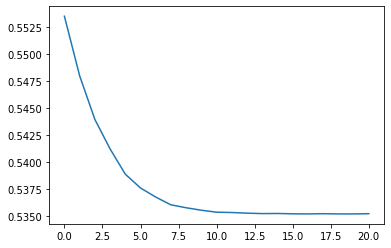

In [27]:
import matplotlib.pyplot as plt
loss = [5.5352e-01 , 
5.4801e-01 , 
5.4397e-01 ,
5.4124e-01 ,
5.3890e-01 ,
5.3762e-01 ,
5.3678e-01 ,
5.3606e-01 ,
5.3579e-01 ,
5.3556e-01 ,
5.3538e-01 ,
5.3535e-01 ,
5.3529e-01 ,
5.3525e-01 ,
5.3526e-01 ,
5.3523e-01 ,
5.3522e-01 ,
5.3524e-01 ,
5.3522e-01 ,
5.3522e-01 ,
5.3524e-01]
plt.plot(range(len(loss)),loss)

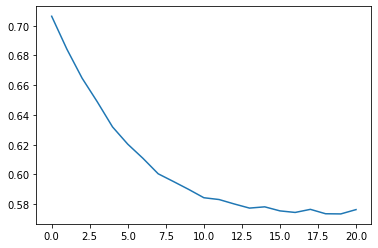

In [29]:
c0 = [7.0635e-01 , 
 6.8422e-01 ,
 6.6472e-01 ,
 6.4879e-01 ,
 6.3195e-01 ,
 6.2036e-01 ,
 6.1083e-01 ,
 6.0045e-01 ,
 5.9527e-01 ,
 5.8997e-01 ,
 5.8436e-01 ,
 5.8315e-01 ,
 5.8016e-01 ,
 5.7739e-01 ,
 5.7824e-01 ,
 5.7552e-01 ,
 5.7447e-01 ,
 5.7655e-01 ,
 5.7359e-01 ,
 5.7348e-01 ,
 5.7638e-01]
plt.plot(range(len(c0)),c0)